# Example:  Frequency Domain Full Waveform Inversion

This example demonstrates how to use `jInv` for estimating the slowness parameter in the 2D Helmholtz equation, which is obtained by applying a Fourier transform on the wave equation in time. The extension to 3D is staightforward but requires a lot more computational resources. Our example is motivated by Full Waveform Inversion (FWI) which, is a geophysical imaging technique. Here, the Helmholtz equation is used to model the propagation of a seismic wave orinating from some point on the surface of the 2D plain for some frequency $\omega$. The waveform in frequency domain of a wave originating in $x_j\in\Omega \subset\mathbb{R}^3$ for a frequency $\omega_{k}$ is modeled by the function $u_{jk} : \Omega \to \mathbb{C}$ that satisfies 

$$
    \begin{split}
	\Delta\, u_{jk}(x) + \omega_{k}^{2}\, (1+\imath \gamma(x))\,  m(x)\,  u_{jk}(x)  = q_{j}(x), \quad  x    \in \Omega,\\
	\quad \nabla u_{jk}(x) \cdot {\vec n} = 0, \quad  x \in \partial \Omega.
\end{split}
$$

where $m : \Omega \to \mathbb{R}^+$ is the squared slowness that needs to be recovered. $q_{j}$ is the source, that is assumed to be a delta function at $x_j$. The attenuation $\gamma : \Omega \to \mathbb{R}^+$ is assumed to be known and is also used to suppress artificial reflections from the boundary of the computational domain using an absorbing layer.

Data measurments of the waveform are given at a number of locations on the surface for each source and frequency, and our goal is to recover $m$ by solving the inverse problem

\begin{equation*}
		\min_{m} \sum_{k} \sum_{j} \| P_j^\top u_{jk}(m) - d_{jk}\|^2 + \alpha \| L m\|^2 
        \quad \text{ subject to} \quad m_L \leq m \leq m_H
\end{equation*}

where 

* $m$ - is the squared slowness
* $u_{jk}$ - is the waveform for the $j$th source and $k$th frequency
* $d_{jk}$ - is the measured data for the $j$th source and $k$th frequency
* $P_j$ - are the receiver matrices
* $\alpha>0$ and $L$ is the regularization parameter and operator, respectively
* $m_L,m_H$ are lower and uppter bounds on the model

## References

A 3D version of this experiment is also described in [1]. The disretized Helmholtz equation is an indefinite complex-valued linear system, which we solve by a direct solver in this example. It can also be solved by the shifted Laplacian method if the grid dimensions are too large. More information regarding the way we treat FWI in 3D can be found in [2]. The test data here is generated using jInv and based on the 3D SEG/EAGE model of a salt reservoir described in [3]. Thus, please see and reference the following papers when using this example:

[1]  Ruthotto L, Treister E, Haber E: [jInv - a flexible Julia package for PDE parameter estimation](http://arxiv.org/abs/1606.07399), arXiv:1606.0739 [cs.MS] 2016

[2] Treister E, Haber E: [Full waveform inversion guided by travel time tomography](https://arxiv.org/abs/1607.00968), arXiv:1607.00968 2016

[3] F. Aminzadeh, B. Jean, and T. Kunz. 3-D salt and overthrust models. Society of Exploration Geophysicists, 1997.

## Forward solvers and parallelization

The solver for the forward problems is either a direct or an iterative methods. In this example we use the direct solver in Julia (MUMPS can be used if available). The iterative solver is implemented in our package [`ForwardHelmholtz.jl`](https://github.com/JuliaInv/ForwardHelmholtz.jl) and is based on the shifted Laplacian multigrid method. Both options are parallelized using shared memory architecture usign OpenMP. As common in practice we have multiple measurements that need to be simulated, and our package treats those in batches - solving a few at the time. If more than one machine is available, more workers need to be initialized and our package automatically parallelize the work over all available workers by distributing the sources between them. 


In [1]:

using MAT
using PyPlot
using EikonalInv
using jInv.InverseSolve
using jInv.Mesh
using jInv.ForwardShare
using jInv.Utils
using jInvVis
using jInv.LinearSolvers
using FWI
using ForwardHelmholtz

## Load Problem Parameters

Some test parameters are given in the mat file `DATA_SEG2D_PARAM.mat`.

In [2]:
dataFilenamePrefix = "./ex2DFWI/DATA_SEG2D";
file      = matread(string(dataFilenamePrefix,"_PARAM.mat"));
n_cells   = file["n"];         # size of mesh used for the model
domain    = file["domain"];    # domain size
omega     = file["omega"];     # list of frequencuies
mref      = file["mref"];      # velocity reference model, also serves as starting guess
waveCoef  = file["waveCoef"];  # Wavelet coefficient for each frequency.
gamma     = file["gamma"];
boundsLow = file["boundsLow"]; # lower bound in velocity 
boundsHigh= file["boundsHigh"];# upper bound in velocity;


## Loading the data and the mesh.

Here we assume that:

1) The file DATA_SEG2D_srcMap.dat and DATA_SEG2D_rcvMap.dat contain a table for the sources and receivers locations respectively. The table is given in format: [id, Xloc(km), Yloc(km)].

2) For each frequency in omega there is a data file DATA_SEG2D_freqX.dat, where X is the value of omega. The table is given in the format: [src id , rcv id, d real, Wd real, d imaginary, Wd imaginary].


In [3]:
Minv = getRegularMesh(domain,n_cells);
if length(omega)==1 # matlab saves a 1 variable array as scalar.
	omega = [omega];
	waveCoef = [waveCoef];
end

### Read receivers and sources files to sparse matrices.
RCVfile = string(dataFilenamePrefix,"_rcvMap.dat");
SRCfile = string(dataFilenamePrefix,"_srcMap.dat");
srcNodeMap = readSrcRcvLocationFile(SRCfile,Minv);
rcvNodeMap = readSrcRcvLocationFile(RCVfile,Minv);
Q = generateSrcRcvProjOperators(Minv.n+1,srcNodeMap); 
Q = Q.*1/(norm(Minv.h)^2);
P = generateSrcRcvProjOperators(Minv.n+1,rcvNodeMap);

### Read the data files to an array of array pointers
Wd   = Array(Array{Complex128,2},length(omega))
dobs = Array(Array{Complex128,2},length(omega))
for k = 1:length(omega)
	omRound = string(round((omega[k]/(2*pi))*100.0)/100.0);
	(DobsFWIwk,WdFWIwk) =  readDataFileToDataMat(string(dataFilenamePrefix,"_freq",omRound,".dat"),srcNodeMap,rcvNodeMap);
		Wd[k] 	= WdFWIwk;
		dobs[k] = DobsFWIwk;

end



## Selecting the Active Set

Sometimes we want to include some voxels from the inversion (for example, close to the boundary / sources / receivers). This can be done by the matrix `Iact` by deleting some columns from a sparse identity matrix. If we do that, the size of the model gets smaller and so we need to update the reference model as well. For a more complicated example see setupFWI.jl in the FWI.jl package.

In [4]:
N     = prod(Minv.n+1);
Iact  = sparse(I,N,N);
mback = zeros(Float64,N);


## Setup FWI Param and Misfit Param

Next, we set up the misfit param for our FWI inverse problem. Here, we use one worker that is going to use all the available cores on its machine (that is since matrices and factorizations can be very memory consuming in this problem). It is important to remember that we can distribute the forward problems among the available workers, but it is advisable only if we have multiple computing nodes (machines). If we use more than one worker, the code split up the data and returns the data indices for each worker in `SourcesSubInd`. This is similar to the EikonalInv package. `batch` indicates how many sources are solved at once. `useFilesForFields` indicates whether we use the disk to store the fields. In this example, we solve all sources at once and hold the fields in memory, but it is advisable to reduce `batch` and use `useFilesForFields` in case of large meshes and/or many sources per computing node because of memory issues.

In [5]:
batch = size(Q,2);         # We solve all the sources at once.
useFilesForFields = false; # a flag whether to store the fields on the disk.			
## Set up a MUMPS direct solver 
# Ainv = getMUMPSsolver([],0,0,2); # Alternatives: 
Ainv = getJuliaSolver();  # 
## Choose the workers for FWI (here, its a single worker)
workersFWI = [1];
## Set up workers and division to tasks per frequencies ######################
(pFor,contDiv,SourcesSubInd) = getFWIparam(omega,waveCoef,vec(gamma),Q,P,Minv,Ainv,workersFWI,batch,useFilesForFields);
pMis = getMisfitParam(pFor, Wd, dobs, SSDFun, Iact,mback);

## Configure the Inversion

In the next block we set parameters for the inversion. In `jInv` we need to select a regularizer, its parameter, and configure the optimization problem by setting upper- and lower bounds, maximum number of iterations for the outer and inner loop, a preconditioner, and a model function. 

In [6]:
## models are usually given in velocity (km/sec). We invert here for the slowness, which is 1/v.
mref 				= velocityToSlow(mref)[1];
t    				= copy(boundsLow);
boundsLow 			= velocityToSlow(boundsHigh)[1];
boundsHigh 			= velocityToSlow(t)[1]; t = 0;
modfun 				= slowToSlowSquared;


maxStep				=0.05*maximum(boundsHigh);

regparams 			= [1.0,1.0,1.0,1e-5];
cgit 				= 8; 
alpha 				= 1e-10;
pcgTol 				= 1e-1;
maxit 				= 8;
HesPrec 			= getExactSolveRegularizationPreconditioner();
regfun(m,mref,M) 	= wdiffusionRegNodal(m,mref,M,Iact=Iact,C=regparams);

pInv = getInverseParam(Minv,modfun,regfun,alpha,mref[:],boundsLow,boundsHigh,
                         maxStep=maxStep,pcgMaxIter=cgit,pcgTol=pcgTol,
						 minUpdate=1e-3, maxIter = maxit,HesPrec=HesPrec);

# Choose Method for Plotting/Storing Intermediate Results

Some inversions might take a long time, so it's useful to store or visualize intermediate results. This way, we can cancel the inversion if, e.g., the regularization parameter is too large/small. The optimization algorithms in jInv provide the current model, the current data and some other info we can use. In this case we just plot the estimated model for comparison

*Remark : * interactive plotting does not work in IJulia notebooks. However, if you copy the code to a `.jl` file you will be able to see the plots being updated through the iteration.

In [7]:
plotting = true;
function plotIntermediateResults(mc,Dc,iter,pInv,PMis,resultsFilename="")
	# Models are usually shown in velocity.
	fullMc = slowSquaredToVelocity(reshape(Iact*pInv.modelfun(mc)[1] + mback,tuple((pInv.MInv.n+1)...)))[1];
	if plotting
		close(888);
		figure(888);
		plotModel(fullMc,false,[],0,[1.5,4.8]);
	end
end

plotIntermediateResults (generic function with 2 methods)

## Run the Frequency Continuation Procedure for the Inversion

We are ready to solve the inverse problem. Here we use the frequency continuation procedure, which in this case runs the projected Gauss Newton method with a projected PCG solver for batches of the frequencies. In iteration 1 it will consider only the first frequency, then the first and second frequency, then the first three frequencies and so on. 


======= New Continuation Stage: selecting continuation batches: 1 to 1=======

i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	2.58e+03	0.00e+00	1.00e-10	1.00e+00	  0
   .1	1.15e+03	1.63e-12			4.47e-01
  2.0	1.15e+03	1.63e-12	1.00e-10	4.47e-01	611
   .1	4.25e+02	1.85e-11			1.65e-01
  3.0	4.25e+02	1.85e-11	1.00e-10	1.65e-01	118
   .1	1.46e+02	2.10e-11			5.66e-02
  4.0	1.46e+02	2.10e-11	1.00e-10	5.66e-02	213
   .1	5.97e+01	2.63e-11			2.31e-02
  5.0	5.97e+01	2.63e-11	1.00e-10	2.31e-02	402
   .1	4.58e+01	2.67e-11			1.78e-02
  6.0	4.58e+01	2.67e-11	1.00e-10	1.78e-02	385
   .1	3.67e+01	2.71e-11			1.42e-02
  7.0	3.67e+01	2.71e-11	1.00e-10	1.42e-02	306
   .1	3.21e+01	2.77e-11			1.24e-02
  8.0	3.21e+01	2.77e-11	1.00e-10	1.24e-02	332
   .1	2.67e+01	2.82e-11			1.03e-02
projGNCG iterated maxIter=8 times but reached only stepNorm of 0.00809745336913581 instead 0.001.

======= New Continuation Stage: selecting continuation batches: 1 to 2=======

i.LS	       F	       R	alpha[1]	   Jc/J0	 #A

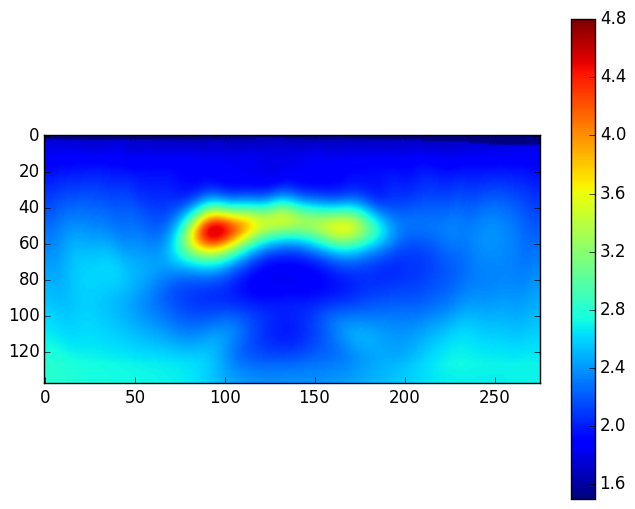

   .1	8.15e+02	2.41e-12			4.19e-01
projGNCG iterated maxIter=8 times but reached only stepNorm of 0.003928212366821837 instead 0.001.


In [8]:
mc,Dc,flag,His = freqCont(copy(mref[:]), pInv, pMis,contDiv, 4, "",plotIntermediateResults,"Joint",1,1,"projGN");

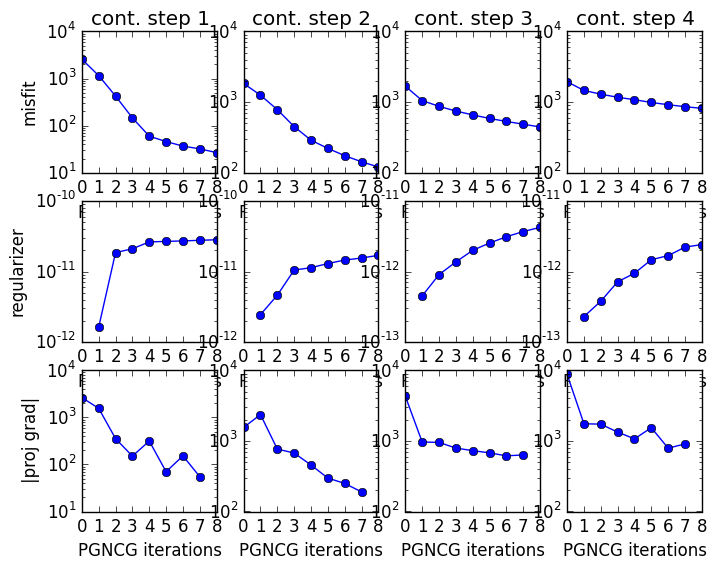

In [35]:
for k=1:4
    subplot(3,4,k)
semilogy(His[k].F,"-o")
xlabel("PGNCG iterations")
    (k==1)&& ylabel("misfit")
    title("cont. step $k")

subplot(3,4,4+k)
semilogy(His[k].Rc,"-o")
xlabel("PGNCG iterations")
    (k==1)&& ylabel("regularizer")

subplot(3,4,8+k)
semilogy(His[k].dJ,"-o")
xlabel("PGNCG iterations")
    (k==1)&& ylabel("|proj grad|")

end

## Visualize Residuals

### Real part 


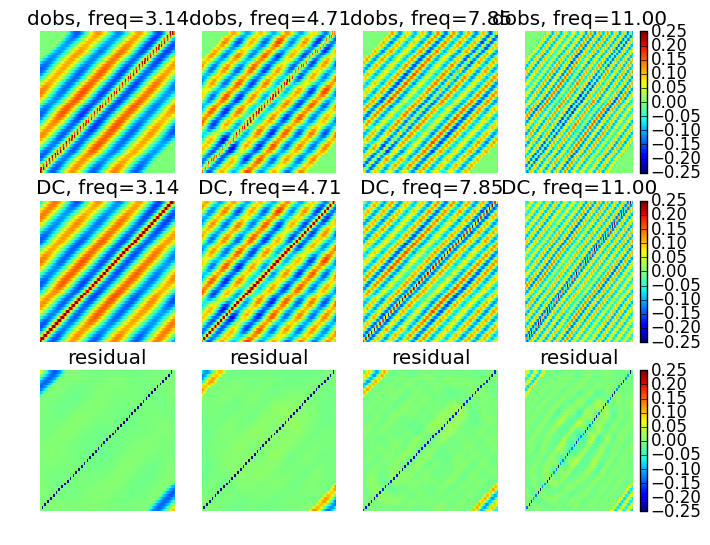

PyObject <matplotlib.colorbar.Colorbar instance at 0x334bddb90>

In [37]:
DC = Array(Array,length(dobs))
for k=1:length(dobs)
    DC[k] = fetch(Dc[k])
end
M2D   = getRegularMesh([0 1 0 1], [240 48])
viewD(d) = (viewImage2D(d,M2D,vmin=-0.25,vmax=.25); axis("off"))

for k=1:4
    subplot(3,4,k)
    viewD(real(dobs[k]))
    title(@sprintf "dobs, freq=%1.2f"  omega[k])
end
colorbar()

for k=1:4
    subplot(3,4,4+k)
    viewD(real(DC[k]))
    title(@sprintf "DC, freq=%1.2f"  omega[k])
end
colorbar()

for k=1:4
    subplot(3,4,8+k)
    viewD(real((dobs-DC)[k]))
    title(@sprintf "residual")
end
colorbar()


### Imaginary part

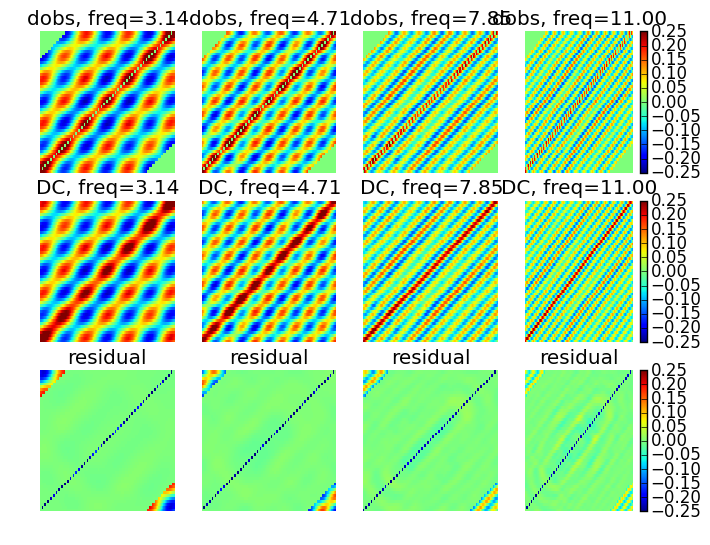

PyObject <matplotlib.colorbar.Colorbar instance at 0x32caad680>

In [36]:
DC = Array(Array,length(dobs))
for k=1:length(dobs)
    DC[k] = fetch(Dc[k])
end
M2D   = getRegularMesh([0 1 0 1], [240 48])
viewD(d) = (viewImage2D(d,M2D,vmin=-0.25,vmax=.25); axis("off"))

for k=1:4
    subplot(3,4,k)
    viewD(imag(dobs[k]))
    title(@sprintf "dobs, freq=%1.2f"  omega[k])
end
colorbar()

for k=1:4
    subplot(3,4,4+k)
    viewD(imag(DC[k]))
    title(@sprintf "DC, freq=%1.2f"  omega[k])
end
colorbar()

for k=1:4
    subplot(3,4,8+k)
    viewD(imag((dobs-DC)[k]))
    title(@sprintf "residual")
end
colorbar()

## Save results

In [39]:
matwrite("exFWI2DRes.mat",Dict("mc"=>mc,"His"=>His))